In [1]:
# import intake
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import numcodecs
import dask
import cartopy.crs as ccrs
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
from iris.time import PartialDateTime


##

* read in data from scratch as iris cubes
* interpolate the aiming result
* plot the interpolated 2D data


In [19]:
# %% list of data to read in
def data_dict(myid):
    if myid == 'slhf':
        mydict = {
            'indir': '/work/bb1153/b381639/IFS',
            'infile': '/work/bb1153/b381639/IFS/slhf_daily_tco1279-orca025.nc',
            'key': iris.Constraint(cube_func=(lambda c: c.var_name == 'slhf'))
        }

    elif myid == 'sshf':
        mydict = {
            'indir': '/work/bb1153/b381639/IFS',
            'infile': '/work/bb1153/b381639/IFS/sshf_daily_tco1279-orca025.nc',
            'key': iris.Constraint(cube_func=(lambda c: c.var_name == 'sshf'))
        }
    elif myid == 'sst':
        mydict = {
            'indir': '/work/bb1153/b381639/IFS',
            'infile': '/work/bb1153/b381639/IFS/sst_daily_tco1279-orca025.nc',
            'key': iris.Constraint(cube_func=(lambda c: c.var_name == 'sst'))
        }  
    return(mydict)

In [20]:
## create correct time cubelist to save output data
cubelist_ct = iris.cube.CubeList()
##readin sfcwind
datasets=['slhf','sshf','sst']  #['ERAI']  # ['u-bt405','u-bt406','u-bm213','u-be034','u-bd818']
for my_dataset in datasets:
    print('--> '+my_dataset)
    mydict = data_dict(my_dataset)
    datain = iris.load_cube(mydict['infile'],mydict['key'])
#    data_time= fx.correct_time(datain)

    cubelist_ct.append(datain)

--> slhf
--> sshf
--> sst


## select the variable and one time step to be interpolated and ploted
> this can be done in the last step of analysis

In [21]:
slhf=cubelist_ct[2]
data_sample=slhf[1,:]
data_arr=xr.DataArray.from_iris(data_sample)
data_arr.shape

(6599680,)

## manage lat and lon
*  get lat lon values from xarray
*  change lon from 0-360 to -180-180, if necessary
*  creat aim grid

In [31]:

model_lon = data_arr.lon.values
model_lat = data_arr.lat.values
#model_lon = np.where(model_lon>180, model_lon-360, model_lon)

lon = np.linspace(100, 300, 200*10)
lat = np.linspace(-20, 20, (20+20)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_icon = np.vstack((model_lon, model_lat)).T

In [32]:
nn_interpolation = NearestNDInterpolator(points_icon, data_arr.values)
interpolated_nn = nn_interpolation((lon2, lat2))
interpolated_nn.shape

(40, 200)

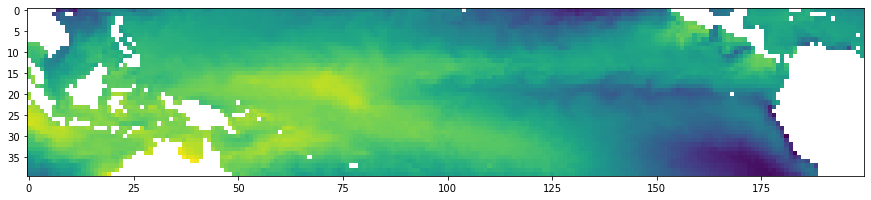

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Model grid

In [55]:
cat = intake.open_catalog("/home/b/b381639/nextGems_Cycle2/catalog.yaml")
#run = cat.IFS["tco2559-ng5"]
#run = cat.IFS["tco1279-orca025"]
run = cat.IFS["tco2559-ng5"]
data = run.ICMGG_atm2d.to_dask()

In [56]:
model_lon = data.lon.values
model_lat = data.lat.values
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

In [ ]:
nn_interpolation = NearestNDInterpolator(points, data_sample.values)


interpolated_nn = nn_interpolation((lon2, lat2))

In [44]:
import numpy as np

lon = np.linspace(120, 270, (270-120))
lat = np.linspace(-20, 20, (20+20))
lon2, lat2 = np.meshgrid(lon, lat)

In [45]:
points = np.vstack((model_lon, model_lat)).T

In [46]:
data_sample = data['2t'].isel(time=100)

In [48]:
nn_interpolation = LinearNDInterpolator(points, data_sample.data)

2023-01-06 13:45:11,846 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-getitem-2ba0900ab5ecf75f2ec8348806f872d2', 0)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffeda2ede00>, key=BasicIndexer((slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7fffb3d79b80>, encoded_fill_values={9999.0}, decoded_fill_value=nan, dtype=dtype('float64')), dtype=dtype('float64')), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))), (100, slice(0, 6599680, None)))
kwargs:    {}
Exception: 'ValueError("codec not available: \'gribscan.rawgrib\'")'



ValueError: codec not available: 'gribscan.rawgrib'

In [25]:
nn_interpolation = NearestNDInterpolator(points, data_sample.values)

2023-01-06 13:37:49,501 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-getitem-3dac813129ab596d8b370f7515803b2c', 0)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffeda4f43c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7fffb57f4310>, encoded_fill_values={9999.0}, decoded_fill_value=nan, dtype=dtype('float64')), dtype=dtype('float64')), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))), (1, slice(0, 6599680, None)))
kwargs:    {}
Exception: 'ValueError("codec not available: \'gribscan.rawgrib\'")'



ValueError: codec not available: 'gribscan.rawgrib'

In [21]:
import numpy as np

lon = np.linspace(120, 270, (270-120))
lat = np.linspace(-20, 20, (20+20))
lon2, lat2 = np.meshgrid(lon, lat)

points = np.vstack((model_lon, model_lat)).T
data_sample = data['2t'].isel(time=1)

nn_interpolation = NearestNDInterpolator(points, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

2023-01-06 13:36:03,450 - distributed.worker - WARNING - Compute Failed
Key:       ('open_dataset-getitem-3dac813129ab596d8b370f7515803b2c', 0)
Function:  getter
args:      (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7fffa79d73c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7fffa360a9d0>, encoded_fill_values={9999.0}, decoded_fill_value=nan, dtype=dtype('float64')), dtype=dtype('float64')), key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))), (1, slice(0, 6599680, None)))
kwargs:    {}
Exception: 'ValueError("codec not available: \'gribscan.rawgrib\'")'



ValueError: codec not available: 'gribscan.rawgrib'

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

<xarray.Dataset>
Dimensions:  (time: 17089, value: 6599680, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2022-01-01
Dimensions without coordinates: value
Data variables: (12/87)
    100si    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ...       ...
    vike     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### press Y in command mod and change it to code to test if the variables are accumulated


var='u10'
test=data[var][1000:2000,100000]
#[150:420,500]
test.plot()

In [23]:
#2t,2d,sst,sp,10u,10v is not accumulated
var='10u'
data1=data[var]#.isel({'time': slice(0,240)})
Varout=xr.zeros_like(data[var][0:713,:])
outdate = data1.resample(time="1D").mean(dim="time") #.compute()


Varout.data=outdate
Varout.coords['time']=outdate.time



### Save needed variables to nc file

In [24]:
Varout

<xarray.DataArray '10u' (time: 713, value: 6599680)>
dask.array<stack, shape=(713, 6599680), dtype=float64, chunksize=(1, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2022-01-01
Dimensions without coordinates: value
Attributes:
    paramId:                    165
    dataType:                   fc
    numberOfPoints:             6599680
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  10u
    units:                      m s**-1
    name:                       10 metre U wind component
    cfVarName:                  u10
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [ ]:
Varout.to_netcdf('/scratch/b/b381639/IFS/'+var+'_daily_tco1279-orca025.nc')

In [ ]:




#creat a output data with all the attribution needed
#Acumunated var slhf, sshf, 
#2t, 2d, sst,sp,tp,10u, 10v
var='sst'
#######################

Varout=xr.zeros_like(data[var][0:711,:])
times = pd.date_range("2020/01/20",periods=711,freq='D',closed='left')
time_da = xr.DataArray(times, [('time', times)])

#########
#Output Varout
#########
Varout.coords['time']=time_da

In [ ]:




#creat a output data with all the attribution needed
#Acumunated var slhf, sshf, 
#2t, 2d, sst,sp,tp,10u, 10v
var='sst'
#######################

Varout=xr.zeros_like(data[var][0:711,:])
times = pd.date_range("2020/01/20",periods=711,freq='D',closed='left')
time_da = xr.DataArray(times, [('time', times)])

#########
#Output Varout
#########
Varout.coords['time']=time_da

In [85]:
#But fluxes are accumulated from start of the month, or for Jan 2020, it would be Jan 20th. 
#So we need to take the difference from day after to current day. 
####VARarray has the unit from J/s to W/day

#creat a calendar array

yyyys=2020
yyyye=2021
yr=yyyys
#day=4
mms=1
mme=12
cdatearr=[]
dayarr=[]

while yr<=yyyye:
    yyyy=str(yr)
    mth=mms
    if yr==yyyye:
        mthe=mme
    else:
        mthe=12
    while mth<=mthe:
        if mth<10:
            mm='0'+str(mth)
        else:
            mm=str(mth)
        if mth==1 or mth==3 or mth==5 or mth==7 or mth==8 or mth==10 or mth==12:
            daye=31
        elif mth==4 or mth==6 or mth==9 or mth==11:
            daye=30
        if (yr%4)==0 and mth==2:
            daye=29
        elif (yr%4)!=0 and mth==2:
            daye=28
        if yr==2020 and mth==1:
            days=20
        else:
            days=1
        day=days
        tidx=0
        while day<=daye:
            if day<10:
                dd='0'+str(day)
            else:
                dd=str(day)
            cdatearr.append(yyyy+'-'+mm+'-'+dd)
            dayarr.append(day)
            #print(data.str.sel(time=yyyy+'-'+mm+'-'+dd+'T00:00:00.000000000').time)
            day=day+1
            #cidx=cidx+1
        mth=mth+1
    yr=yr+1

print(np.shape(cdatearr)[0]-1)
#print(cdatearr)

711


In [86]:
# day2-day1 = day2_daily

VARarray=[]
cidx=0
while cidx<=np.shape(cdatearr)[0]-2:
    cdate=cdatearr[cidx]
    cdatep=cdatearr[cidx+1]
    #print(dayarr[cidx+1])
    #dlen=len(dayarr[cidx+1])
    if dayarr[cidx+1]==2 or cidx==0:
        #print('Use only '+cdatep)
        #print('datestamp='+cdate+'T00:00:00.000000000')
        VARarray.append(data[var].sel(time=cdatep+'T00:00:00.000000000').reset_coords('time', drop=True) /86400)


        #print(SHF.max())
    else:
        #print('Use '+cdatep+' - '+cdate)
        VARarray.append((data[var].sel(time=cdatep+'T00:00:00.000000000')-data[var].sel(time=cdate+'T00:00:00.000000000') )/86400)   

        #SHFarray.append(SHF)
    cidx=cidx+1

Varout.data=xr.concat(VARarray,dim='time')
Varout.coords['time']=time_da
Varout.attrs['units']='W m**-2'

In [87]:
Varout.to_netcdf('/scratch/b/b381639/IFS/'+var+'_daily_tco1279-orca025.nc')